# Import Libraries

In [1]:
import os
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scipy.optimize
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import BSpline

/opt/miniconda3/envs/wb1/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Direct flood exposure

In [ ]:
# exposure dfs
btw_79_90_exposure_raw = pd.read_csv("../../01_data/csv/flood_exposure_percent_79_90_flooded_649_records.csv", index_col=0)
grth_90_exposure_raw = pd.read_csv("../../01_data/csv/flood_exposure/flood_exposure_percent_grth_90_flooded_1967_records.csv", index_col=0)
exposure_raw_combined = btw_79_90_exposure_raw.append(grth_90_exposure_raw)

# exposure in total meters
exposure_tot_meters = exposure_raw_combined.reset_index().rename(columns={'index':'id'})
exposure_tot_meters.to_csv("../../01_data/csv/exposure_tot_meter_2616_records.csv")

# exposure in percentage
exposure_tot_percentage = exposure_tot_meters[['id', 'total_road_length']].join(exposure_tot_meters.iloc[:,1:-1].div(exposure_tot_meters.total_road_length /100, axis=0))
exposure_tot_percentage.to_csv("../../01_data/csv/exposure_tot_percentage_2616_records.csv")

In [ ]:
exposure_tot_percentage.drop(columns=['total_road_length'])
thresholds = [0.15, 0.2, 0.25, 0.3]

threshold_stack = pd.DataFrame()
for threshold in thresholds:
    threshold_df = exposure_tot_percentage.filter(regex=str(threshold)+'$',axis=1)
    threshold_df.columns = ['RP_5', 'RP_10', 'RP_20', 'RP_50', 'RP_75', 'RP_100',
                            'RP_200', 'RP_250', 'RP_500', 'RP_1000']
    threshold_df = exposure_tot_percentage[['id']].join(threshold_df)
    threshold_df['threshold'] = threshold
    threshold_stack = pd.concat([threshold_stack, threshold_df], ignore_index=True)

# Save the stacked version as new csv file
threshold_stack.to_csv("../../01_data/csv/exposure_tot_percentage_2616_records_stacked.csv")

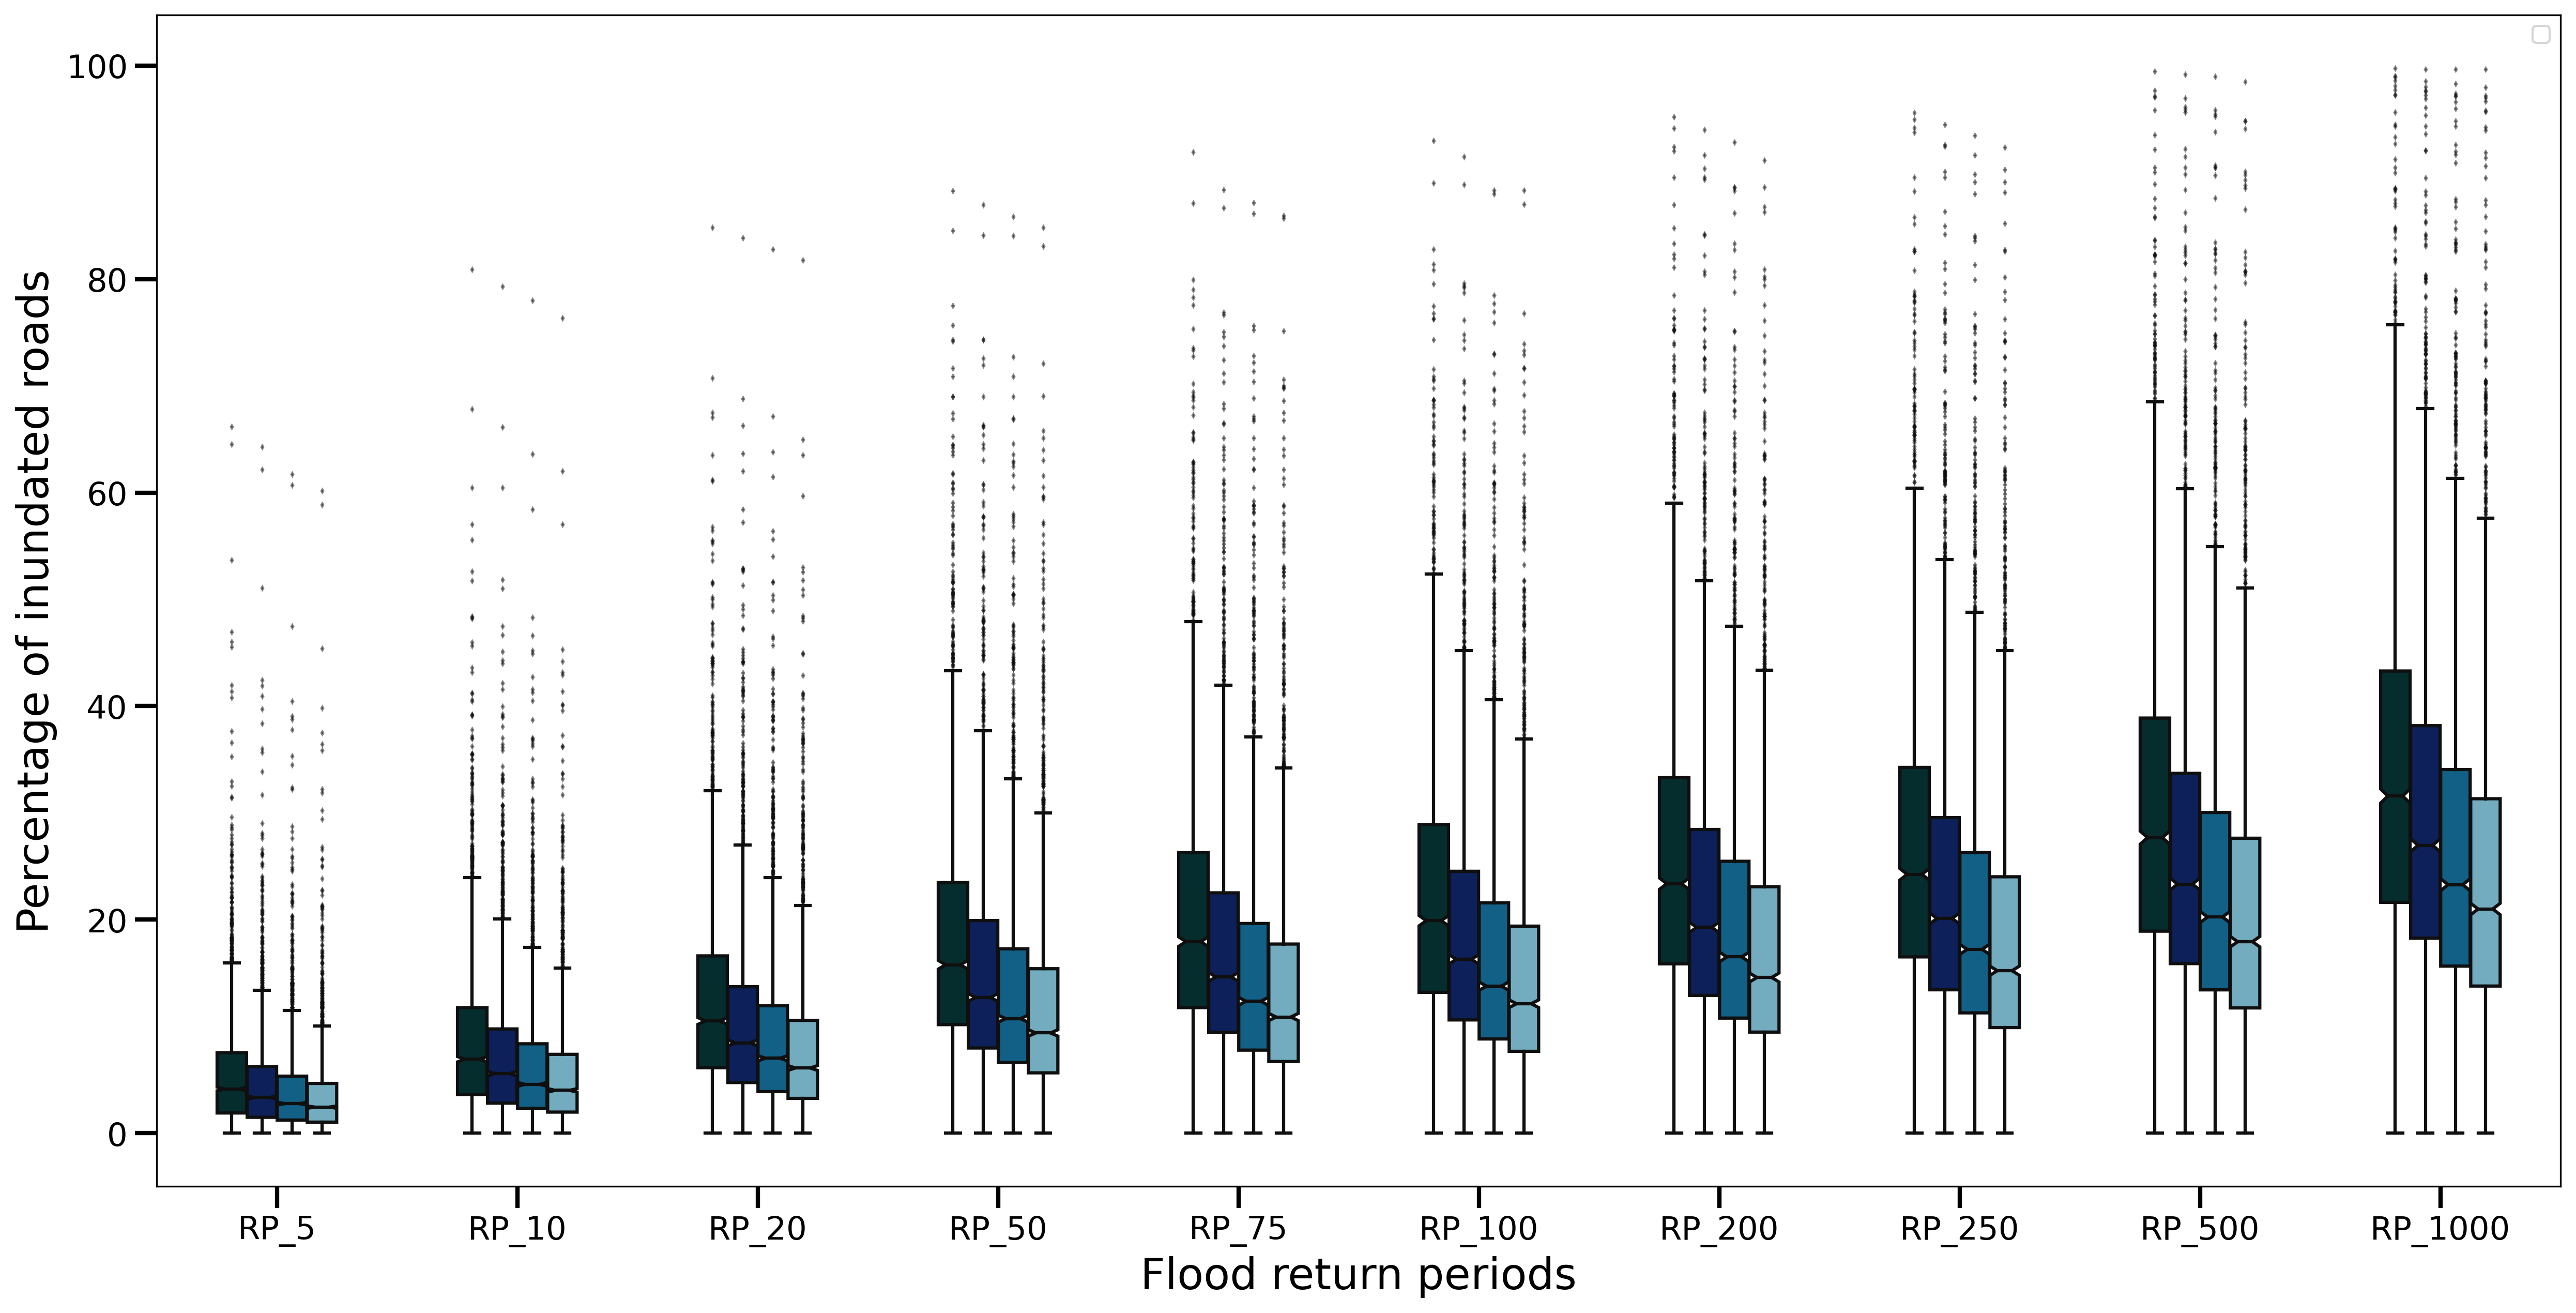

In [4]:
threshold_stack = pd.read_csv("../../01_data/csv/exposure_tot_percentage_2616_records_stacked.csv", index_col=0)
plt.figure(dpi=300, figsize=(20,10))

df_melt = pd.melt(threshold_stack, id_vars=['id', 'threshold'], 
                  value_vars=['RP_5', 'RP_10', 'RP_20', 'RP_50', 'RP_75',
                              'RP_100', 'RP_200', 'RP_250', 'RP_500', 'RP_1000'])

sns.boxplot(x="variable", y="value", hue="threshold", data=df_melt, palette="ocean", notch=True, width=0.5,
            flierprops = dict(markersize = 1, alpha=0.5))

plt.xticks(fontsize = 15)
plt.xlabel('Flood return periods', fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Percentage of inundated roads', fontsize = 20)
plt.legend('')
plt.tick_params(length=10, width=2)

# Percent failed routings & percent exposure

In [ ]:
# Read percent failed routings dataframe
failed_routings_df = pd.read_csv('../../01_data/csv/percent_failed_routes/percent_failed_routings_df.csv', index_col=0)
# Read percent exposure dataframe
exposure_tot_percentage_stacked_df = pd.read_csv('../../01_data/csv/flood_exposure/exposure_tot_percentage_2616_records_stacked.csv', index_col=0)

threshold_value = 25
# Set flood return period
# List of flood return periods
flood_10_rps = [5, 10, 20, 50, 75, 100, 200, 250, 500, 1000]
fail_exposure_percentage_join_10_rps = failed_routings_df[failed_routings_df['threshold'] == 15][['net_id']]

for RP_value in flood_10_rps:
    
    failed_routings_df_select = failed_routings_df[['net_id']].join(\
        failed_routings_df[failed_routings_df['threshold']==threshold_value].filter(\
        regex='P_'+str(RP_value)+'$',axis=1)).dropna()
    exposure_tot_percentage_select = exposure_tot_percentage_stacked_df[['id']].join(\
        exposure_tot_percentage_stacked_df[exposure_tot_percentage_stacked_df['threshold']==(threshold_value/100)].filter(\
        regex='P_'+str(RP_value)+'$',axis=1)).dropna()

    fail_exposure_percentage_join = pd.merge(failed_routings_df_select, exposure_tot_percentage_select,
                                            left_on='net_id', right_on='id', how='left').\
                                    rename(columns={'FUP_'+str(RP_value): 'fail_perc_'+str(RP_value),
                                                  'RP_'+str(RP_value): 'expose_perc_'+str(RP_value)}).\
                                    drop(columns='id')
    
    fail_exposure_percentage_join_10_rps = pd.merge(fail_exposure_percentage_join_10_rps,
                                                    fail_exposure_percentage_join,
                                                    left_on='net_id',
                                                    right_on='net_id')
fail_exposure_percentage_join_10_rps['threshold'] = threshold_value
fail_exposure_percentage_join_10_rps.to_csv('../../01_data/csv/fail_exposure_percentage_join_10_rps_'\
                                            + str(threshold_value)\
                                            + 'cm.csv')

(0.0, 100.0)

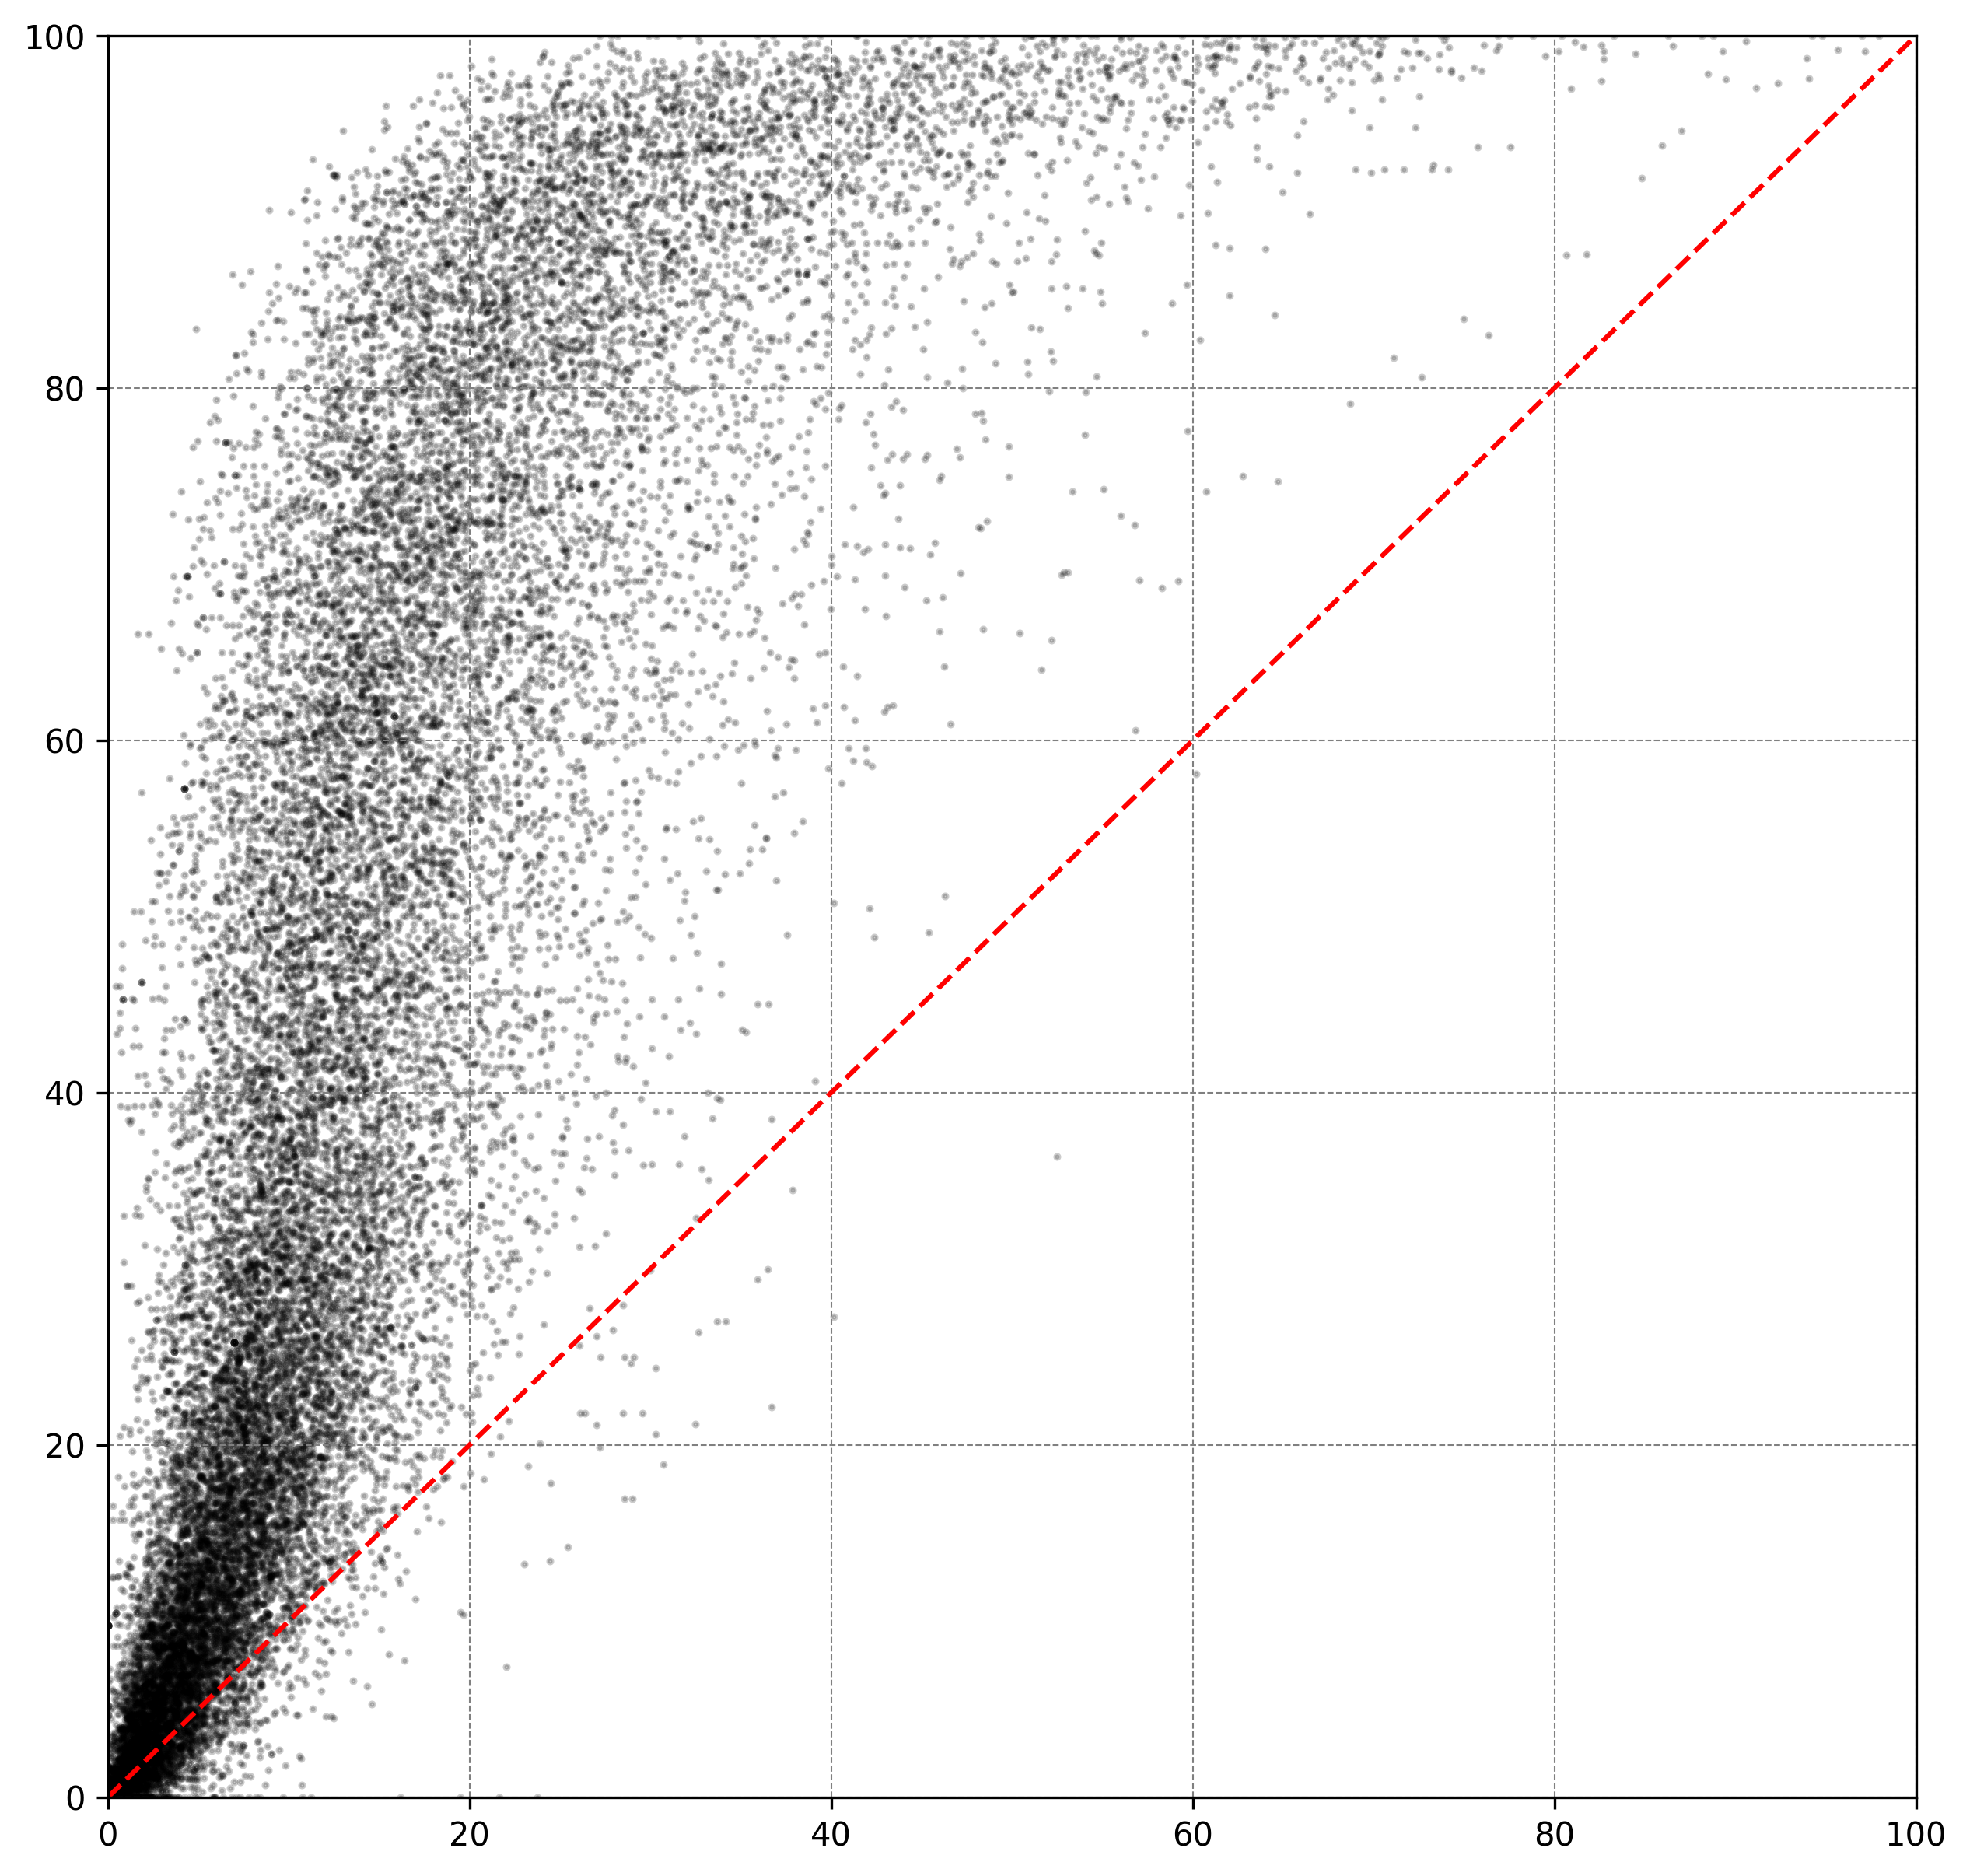

In [6]:
# Scatter plot
flood_10_rps = [5, 10, 20, 50, 75, 100, 200, 250, 500, 1000]
colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8',
          '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
# https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=10
# Read dataframe
fail_exposure_percentage_join_10_rps = pd.read_csv('../../01_data/csv/fail_exposure_percentage_join_10_rps_30cm.csv',
                                                  index_col=0)

plt.figure(dpi=300, figsize=(10,10))
for i, rp in enumerate(flood_10_rps):
    plt.scatter(fail_exposure_percentage_join_10_rps[f'expose_perc_{rp}'].values,
                fail_exposure_percentage_join_10_rps[f'fail_perc_{rp}'].values, c='k',
               alpha=0.2, s=8, marker='.')

plt.plot([0, 100], [0, 100], c='r', linestyle='--')
plt.grid(True, color='grey', linestyle='--', linewidth=0.5, zorder=0)
plt.xlim(xmin=0, xmax=100)
plt.ylim(ymin=0, ymax=100)
# plt.savefig(f'/Users/yiyihe/Desktop/percent_expo_percent_failed_scatter.png')

# Direct exposure by threshold 0-5m

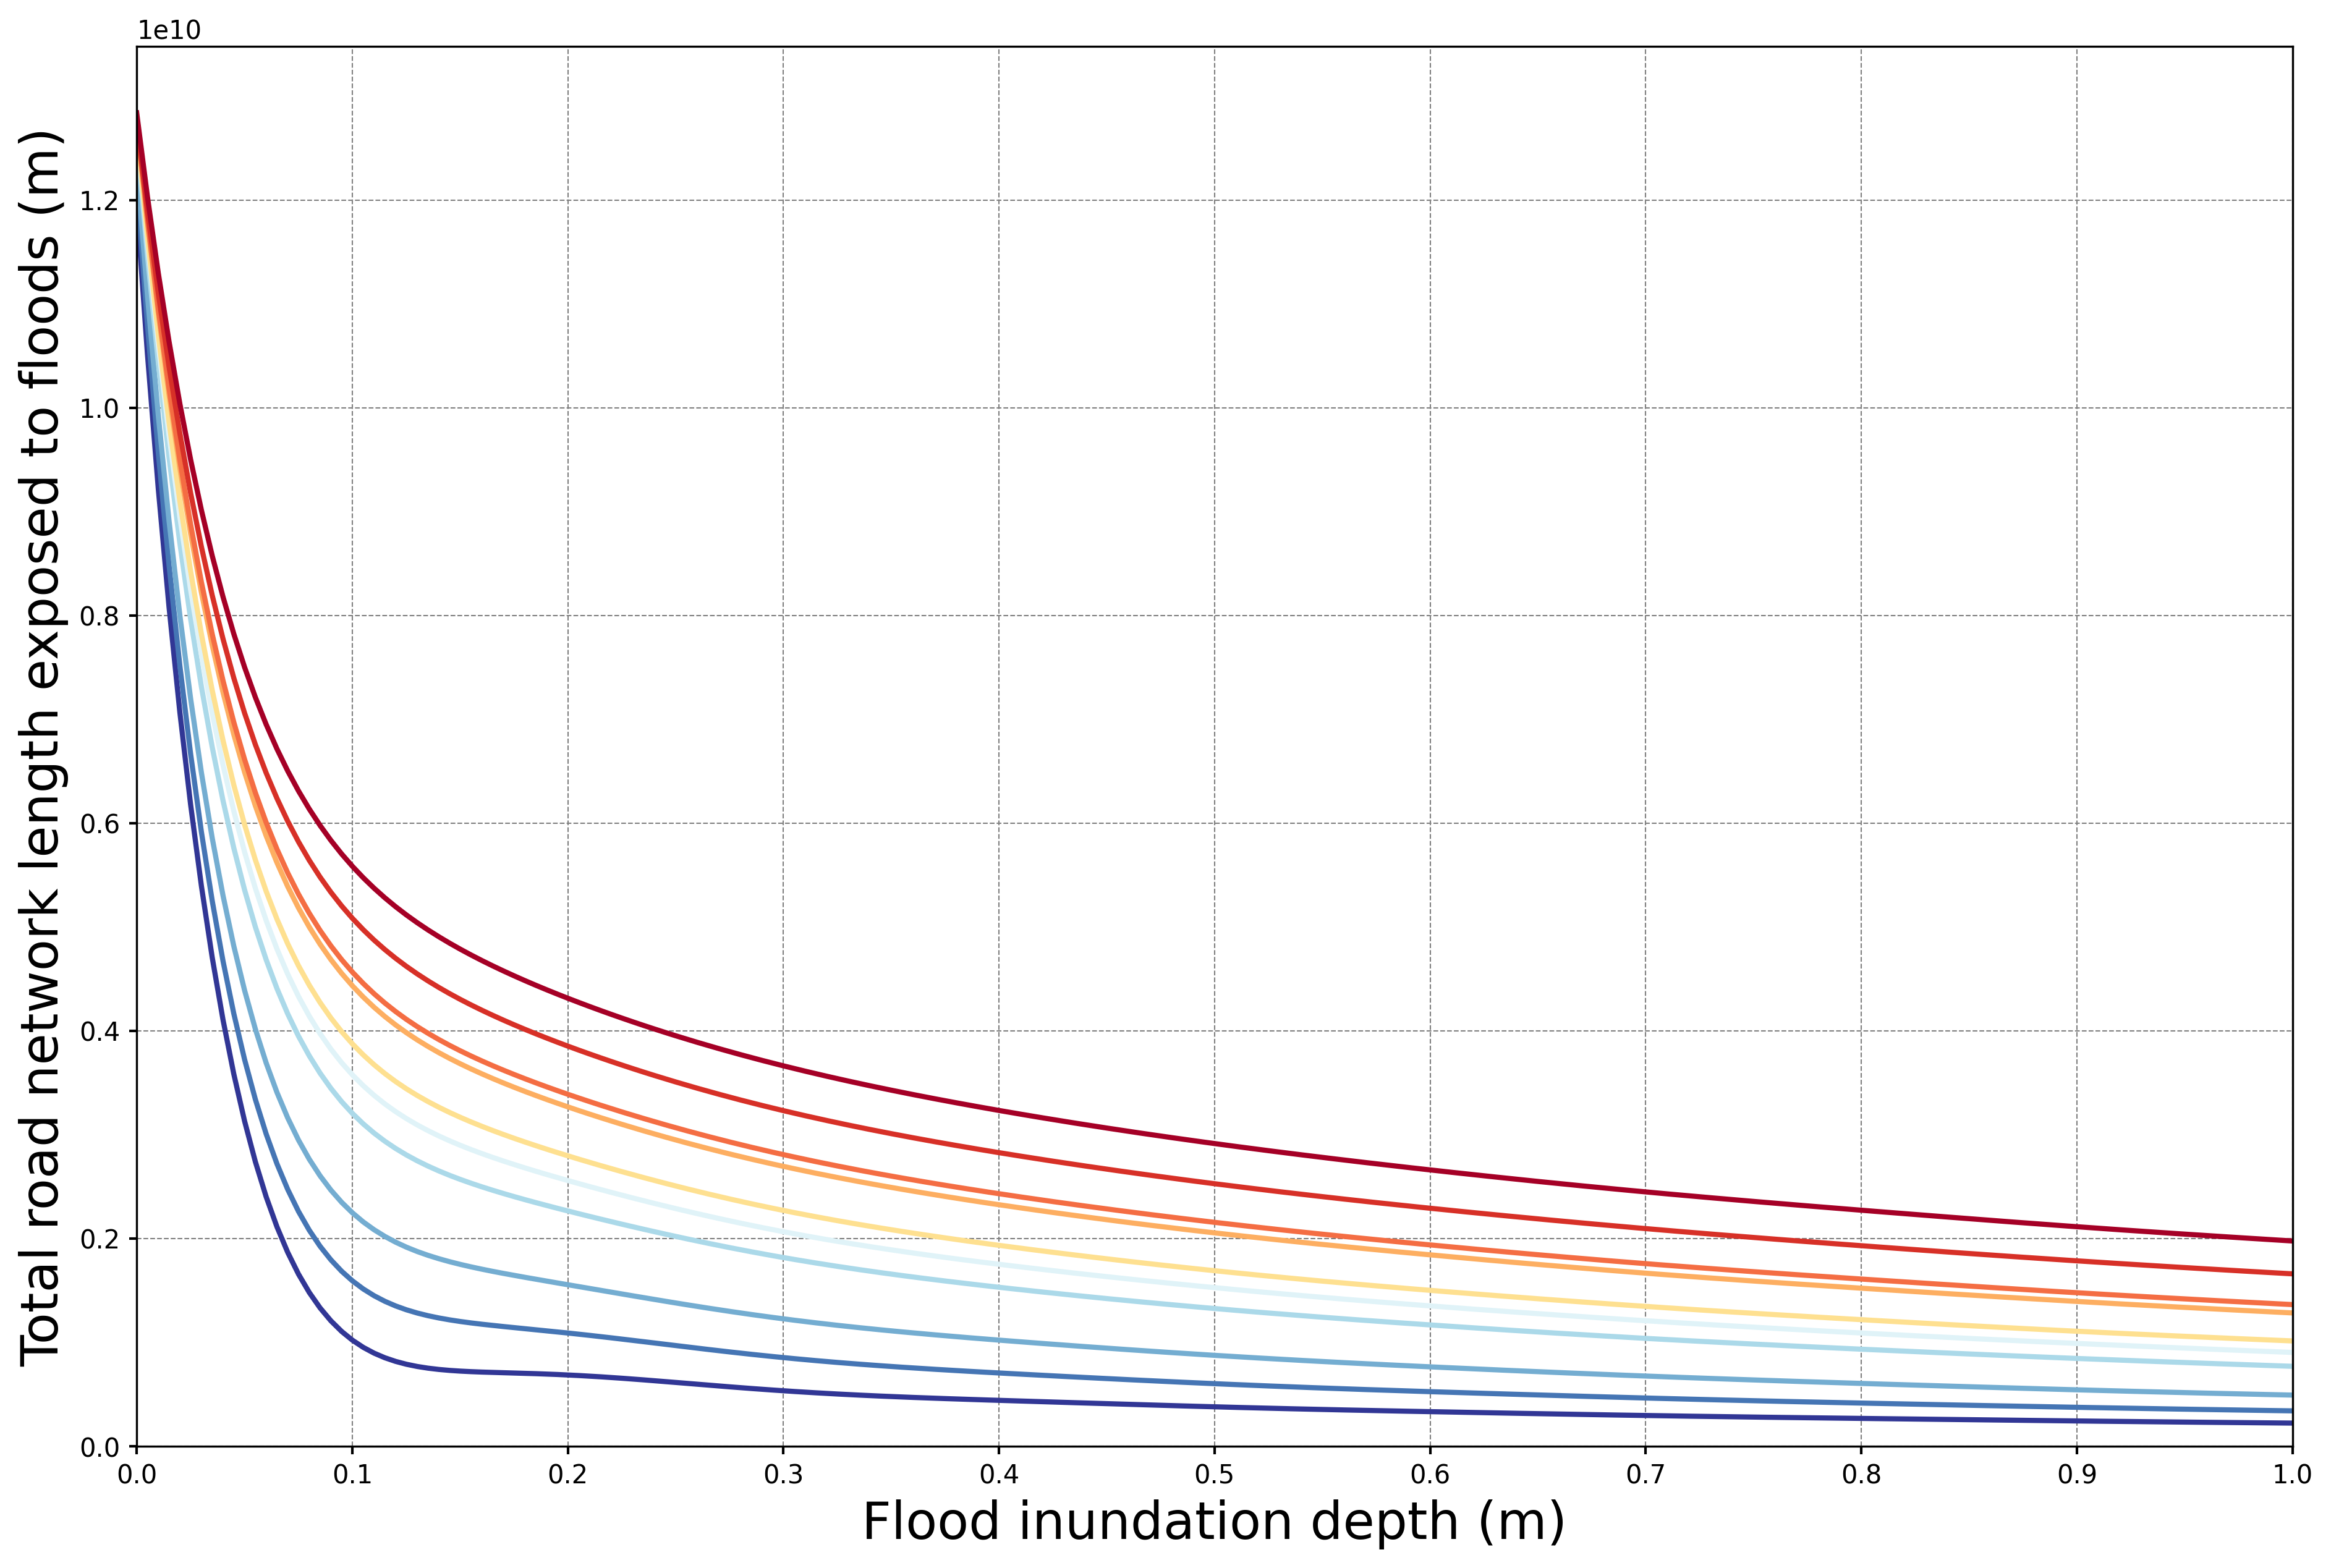

In [7]:
exposure_sensitivity_raw = pd.read_csv('../../01_data/csv/exposure_sensitivity_raw_summary.csv',
                                      index_col=0)
exposure_by_rp = exposure_sensitivity_raw.groupby(['RP']).sum()

flood_10_rps = [5, 10, 20, 50, 75, 100, 200, 250, 500, 1000]
colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8',
          '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']

df = exposure_by_rp.loc[:, exposure_by_rp.columns.drop('net_id')].T

def model_func(t, A, K, C):
    return A * np.exp(K * t) + C
def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = scipy.optimize.curve_fit(model_func, t, y, maxfev=100000)
    A, K, C = opt_parms
    return A, K, C

plt.figure(dpi=300, figsize=(15,10))
for i, rp  in enumerate(flood_10_rps):
    x = np.array([float(i) for i in df.index])
    y = df[rp].values
    
    X_Y_Spline = make_interp_spline(x, y)
    cubic_interploation_model = interp1d(x, y, kind = "quadratic")
    ius = InterpolatedUnivariateSpline(x, y)
    rbf = Rbf(x, y)
    
#     A, K, C = fit_exp_nonlinear(x, y)
#     fit_y = model_func(x, A, K, C)
    
    X_ = np.linspace(x.min(), x.max(), 1000)
#     Y_ = cubic_interploation_model(X_)
    

    spl = make_interp_spline(x, y, k=9)  # type: BSpline
    Y_ = spl(X_)
    
    plt.plot(X_, Y_, color=colors[i], linewidth=2)
#     plt.plot(x, fit_y, color=colors[i])
#     plt.plot(x, y, color=colors[i], label=rp)

plt.xlim(xmin=0, xmax=1)
plt.ylim(ymin=0)
plt.xticks(x[:11])
plt.xlabel('Flood inundation depth (m)', fontsize = 20)
plt.ylabel('Total road network length exposed to floods (m)', fontsize = 20)
plt.tick_params(length=3, width=1)
plt.grid(True, color='grey', linestyle='--', linewidth=0.5, zorder=0)
# plt.legend()
# plt.yscale('log')
# plt.xscale('symlog')
# plt.yscale('log')
# plt.savefig(f'/Users/yiyihe/Desktop/direct_exposure_by_inundation.png')

# Travel delay and distance increase

In [13]:
thresholds = [15, 20, 25, 30]
dropna_15mm = pd.read_csv('../../01_data/csv/avg_travel_time_distance_15cm_2566.csv', 
                          index_col=0).dropna()
dropna_20mm = pd.read_csv('../../01_data/csv/avg_travel_time_distance_20cm_2568.csv',
                          index_col=0).dropna()
dropna_25mm = pd.read_csv('../../01_data/csv/avg_travel_time_distance_25cm_2572.csv',
                          index_col=0).dropna()
dropna_30mm = pd.read_csv('../../01_data/csv/avg_travel_time_distance_30cm_2576.csv',
                          index_col=0).dropna()

dropna_15mm['threshold'] = 15
dropna_20mm['threshold'] = 20
dropna_25mm['threshold'] = 25
dropna_30mm['threshold'] = 30

drop_na_concat = pd.concat([dropna_15mm.reset_index(drop=True),
                            dropna_20mm.reset_index(drop=True),
                            dropna_25mm.reset_index(drop=True),
                            dropna_30mm.reset_index(drop=True)], axis=0)

plt.figure(dpi=300, figsize=(40,25))

rps = [5, 10, 20, 50, 75, 100, 200, 250, 500, 1000]
df_melt = pd.melt(drop_na_concat, id_vars=['net_id', 'threshold'], 
                  value_vars=['FUP' + str(rp) + '_avg_delay' for rp in rps])

sns.boxplot(x="variable", y="value", hue="threshold", data=df_melt, palette="Reds",
            notch=True, width=0.6, orient='v',
            flierprops = dict(markersize = 1, alpha=0.5))

plt.xticks(fontsize = 15)
plt.xlabel('Flood return periods', fontsize = 20)
plt.yticks([60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720], fontsize = 15)
plt.ylabel('travel delay (seconds)', fontsize = 20)
plt.legend('')
# plt.yscale('log')
plt.tick_params(length=15, width=4)
sns.despine()
plt.ylim(ymax=720, ymin=0)
# plt.savefig('/Users/yiyihe/Desktop/WorldBank/City_Resilience/04_maps/travel_delay_dis_increase_dropna/travel_delay_dropna.png')

(0.0, 720.0)

In [14]:
plt.figure(dpi=300, figsize=(40,25))

rps = [5, 10, 20, 50, 75, 100, 200, 250, 500, 1000]
df_melt = pd.melt(drop_na_concat, id_vars=['net_id', 'threshold'], 
                  value_vars=['FUP' + str(rp) + '_avg_dis_increase' for rp in rps])

sns.boxplot(x="variable", y="value", hue="threshold", data=df_melt, palette="Blues",
            notch=True, width=0.6,
            flierprops = dict(markersize = 1, alpha=0.5))

plt.xticks(fontsize = 15)
plt.xlabel('flood return periods', fontsize = 20)
plt.yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], fontsize = 15)
plt.ylabel('travel distance increase meters', fontsize = 20)
plt.legend('')
# plt.yscale('log')
plt.tick_params(length=15, width=4)
sns.despine()
plt.ylim(ymax=10000, ymin=0)
# plt.savefig('/Users/yiyihe/Desktop/WorldBank/City_Resilience/04_maps/travel_delay_dis_increase_dropna/travel_distance_increase_dropna.png')

(0.0, 10000.0)